<h1>ACDC Implementation Demo</h1>

<p>This notebook gives a low-level explanation of how the forward passes and algorithm that iterates over the computational graph work in the ACDC codebase.</p>

<h3>Setup</h2>

<p>Janky code to do different setup when run in a Colab notebook vs VSCode (adapted from e.g <a href="https://github.com/neelnanda-io/TransformerLens/blob/5c89b7583e73ce96db5e46ef86a14b15f303dde6/demos/Activation_Patching_in_TL_Demo.ipynb">this notebook</a>)</p>

<p>You can ignore warnings that "packages were previously imported in this runtime"</p>

In [1]:

try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

    import subprocess # to install graphviz dependencies
    command = ['apt-get', 'install', 'graphviz-dev']
    subprocess.run(command, check=True)

    from IPython import get_ipython
    ipython = get_ipython()

    ipython.run_line_magic( # install ACDC
        "pip",
        "install git+https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git@d89f7fa9cbd095202f3940c889cb7c6bf5a9b516", 
    )

except Exception as e:
    IN_COLAB = False
    print("Running outside of Colab notebook")

    import numpy # crucial to not get cursed error
    import plotly

    plotly.io.renderers.default = "colab"  # added by Arthur so running as a .py notebook with #%% generates .ipynb notebooks that display in colab
    # disable this option when developing rather than generating notebook outputs

    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        print("Running as a notebook")
        ipython.run_line_magic("load_ext", "autoreload")  # type: ignore
        ipython.run_line_magic("autoreload", "2")  # type: ignore
    else:
        print("Running as a .py script")

Running outside of Colab notebook
Running as a notebook



<h1> What are the two goals of ACDC? </h1>

<p> In order to motivate the technical details on how we implement editable computational graphs, let's first state the the two goals the computational graph implementation has: </p>

<p> 1. We want every node in the computational graph in a model to be a tuple of i) a HookPoint name string and ii) an index into what the tensor that HookPoint takes as input. </p>

<p> 2. We do not any transformer computations to be done inside the hooks that we add to the model to edit the forward pass </p>

<p> For an example of 1, the output of the 0th attention head in the 0th layer of a transformer is the tuple of `"blocks.0.attn.hook_result"` and the index `[:, :, 0, :]`, because the `hook_result` HookPoint has input tensor with dimensions `[batch, pos, head_index, d_model]`. </p>

<p> 2 is a design choice, as it is not elegant to reimplement attention calculations when this has already been done in TransformerLens. This decision does increase complexity of the computational graph setup, as we'll see in "placeholder" edges are added to our computational graphs. </p>

In [2]:
import pygraphviz as pgv
import numpy as np
import subprocess
from transformer_lens import HookedTransformer
from acdc.TLACDCExperiment import TLACDCExperiment, TLACDCCorrespondence
from acdc.TLACDCEdge import TorchIndex
from acdc.acdc_graphics import show
import torch
from IPython.display import display, Image


<h1> Running example definition </h1>

<p> Let's use a 1-Layer transformer with exactly one attention head as an illustration of the ACDC computational graph implementation. </p>

<p> The reason to focus on subsets of edges in transformer computational graphs rather than subsets of nodes is that we can distinguish between the effect model components in Layer 0 have on Layer 1 independently from the effect model components have on Layer 2, i.e the lesson from <a href="https://transformer-circuits.pub/2021/framework/index.html">A Mathematical Framework for Transformer Circuits</a>. </p> 

<p> Therefore we'll start our discussion with a drawing of the components of our transformer that have a direct effect on the end state of the residual stream. Let's setup the model, and show the two direct effect edges on the output. We're just using objects for vizualization purposes here, but this should make understanding the `receiver_hook` easier. We call these edges addition edges, because the final state of the residual stream is the sum of the previous contributions. </p>

In [3]:

# Load a 1-Layer transformer
cfg = {'n_layers': 1,
    'd_model': 1,
    'n_ctx': 1,
    'd_head': 1,
    'model_name': 'GELU_1L512W_C4_Code',
    'n_heads': 1,
    'attn_only': True,
    "d_vocab": 1,
}
transformer = HookedTransformer(cfg)

# Add some extra HookPoints that ACDC needs
transformer.set_use_attn_result(True)
transformer.set_use_split_qkv_input(True)

# Load the correspondence; this represents the graph-like object in ACDC
correspondence = TLACDCCorrespondence.setup_from_model(model=transformer)

In [4]:

# Edit to show the two addition edges

end_state_name = "blocks.0.hook_resid_post"
head_name = "blocks.0.attn.hook_result"
embeds_name = "blocks.0.hook_resid_pre"

head_index = TorchIndex([None, None, 0])
null_index = TorchIndex([None])

# We're using ACDC code to pretend these edges have an effect size (this notebook is just for vizualization purposes)

correspondence.edges[end_state_name][null_index][head_name][head_index].effect_size = 1.0
correspondence.edges[end_state_name][null_index][embeds_name][null_index].effect_size = 1.0

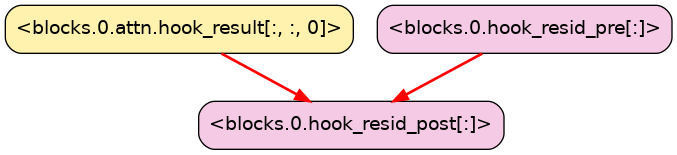

In [5]:

# Make a graphic!

def show_corr(corr):
    show(corr, "correspondence.png", show_full_index=True, edge_type_colouring=True, seed=42, show_placeholders=True)
    display(Image("correspondence.png"))

show_corr(correspondence)


<p> We now need to introduce a second type of edge, which we'll call a "placeholder" edge. </p>


In [6]:

for letter in "qkv":
    e = correspondence.edges[head_name][head_index][f"blocks.0.attn.hook_{letter}"][head_index]
    e.effect_size = 1.0

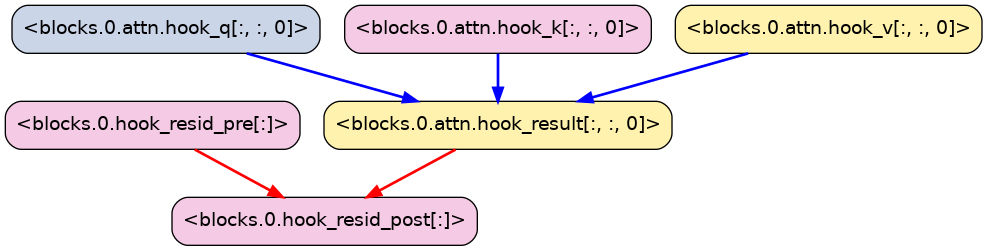

In [7]:

show_corr(correspondence)


<p>These edges have to be different from the two addition edges, because an attention head is NOT the sum of its computed queries, keys and values (these tensors aren't even the correct shape!) </p>

<p>In fact, because of the condition 2 we do not want to do any transformer computation inside the hooks editing the forward pass, and so we actually just include all placeholder edges in ACDC graphs by default! Have no fear however, our next trick will show that this is a totally reasonable thing to do. While we always add placeholder edges under the hood in ACDC, we don't generally show these in the printouts. You'll see why once you understand the third **and final** type of edge, the direct computation edge. Here's a colour guide: </p>



<p> <span style="color:red"> Red </span> edges are addition edges. </p>
<p> <span style="color:blue"> Blue </span> edges are placeholder edges. </p>
<p> <span style="color:green"> Green </span> edges are direct computation edges. </p>


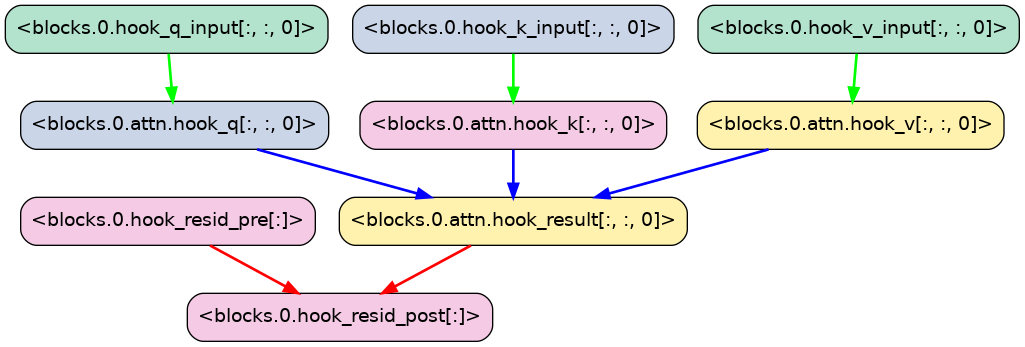

In [8]:

for letter in "qkv":
    e = correspondence.edges[f"blocks.0.attn.hook_{letter}"][head_index][f"blocks.0.hook_{letter}_input"][head_index]
    e.effect_size = 1.0

show_corr(correspondence)


<p> We make a rule: if an node has an incoming direct computation edge (like `blocks.0.attn.hook_q[:, :, 0]`), then we do not allow it to have any other incoming edges. </p>

<p> Why? This means that we have the lovely property that we don't need do computation inside the hooks: all we need to do is store the value of `blocks.0.attn.hook_q[:, :, 0]` on the corrupted data point. Then by the ACDC algorithm, if the direct computation edge is included in the ACDC computational graph, we do nothing and let the `hook_q` compute the query vector. Alternatively, if this edge is not present, we simply overwrite `hook_q` with the corrupted queries. In both cases, no new transformer computation is done in the hook! </p>

<p> Let's round this out with all the edges in this computational graph: </p> 


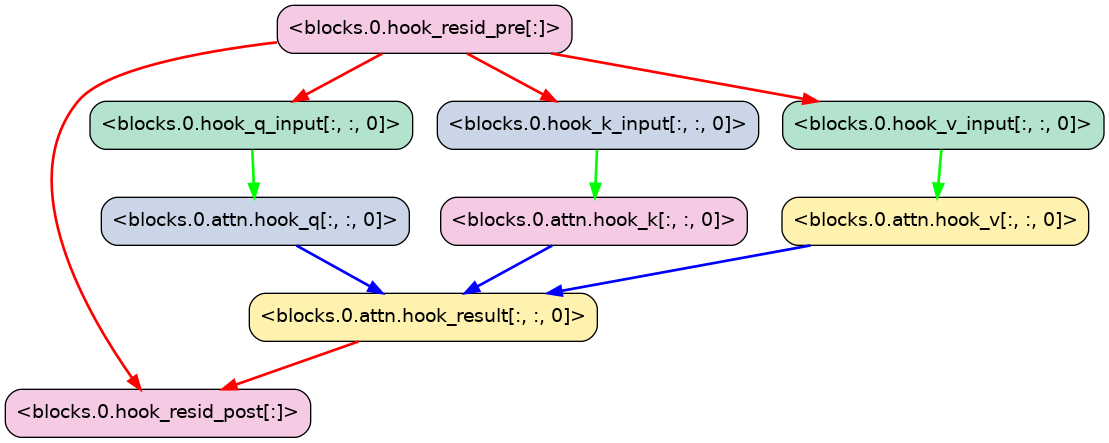

In [9]:

for _, edge in correspondence.all_edges().items():
    edge.effect_size = 1.0

show_corr(correspondence)


<p> That's it! You'll want to check the `receiver_hook` in `TLACDCExperiment` for how we implement the addition and direct computation edges, and also check how we use MLPs (it's much easier, just a `mlp_in` and `mlp_out` node connected by a direct computation edge). </p>

<p> I'd love to see extensions of these abstractions; for example it extends easily to splitting by positions: https://github.com/ArthurConmy/Automatic-Circuit-Discovery/pull/44 and neurons. </p> 